# Experimentation with Ultrasound

1. Acquisition
2. Detection
3. Isolation
4. Localization
5. Tracking
6. Mapping

In [2]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation

## Load US Video

In [3]:
us_dict = scipy.io.loadmat('bfRFC.mat')
us_vid = us_dict['bfRFC'].astype('double')

In [4]:
us_vid = np.moveaxis(us_vid,2,0)

## Produce Gif

In [5]:
def prodGif(vid,fileName):
    fig = plt.figure()
    ax = plt.axes()

    img = ax.imshow(vid[0])

    ax.set_aspect('equal', adjustable='box')
    ax.tick_params(axis='both',bottom=False,left=False,labelleft=False,labelbottom=False)

    def update(frame):
        img.set_data(vid[frame])
        plt.title(f"Frame: {frame}")
        return img

    ani = animation.FuncAnimation(fig=fig, func=update, frames=vid.shape[0])

    writer = animation.PillowWriter(fps=24,
                                    metadata=dict(artist='Jun Ikeda'),
                                    bitrate=1800)

    ani.save(fileName, writer=writer)

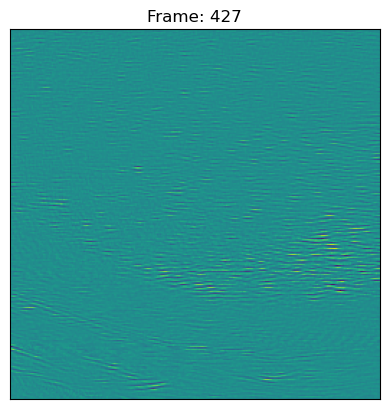

In [5]:
prodGif(us_vid,'unfiltered_us.gif')

## Filter w/ SVD

In [6]:
def casoratiMat(vid):
    #reshape into spatiotemporal representation
    C = vid.reshape(-1,vid.shape[0])
    return C

### Compute Casorati Matrix

In [7]:
C = casoratiMat(us_vid)

### Compute SVD of C

In [9]:
U, S, Vh = np.linalg.svd(C,full_matrices=False)

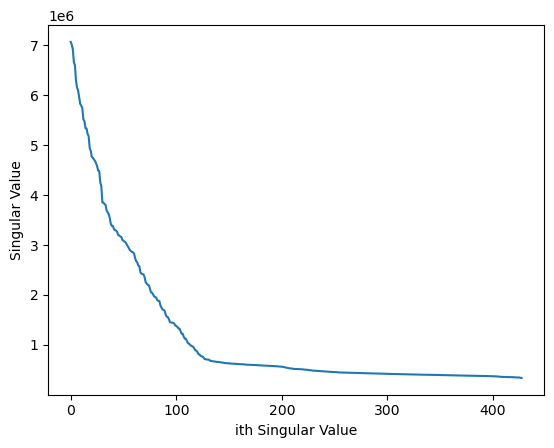

In [11]:
plt.plot(S)
plt.xlabel("ith Singular Value")
plt.ylabel("Singular Value")
plt.show()

### (1) SVD–Arbitrary Threshold

#### Arbitrary Threshold to Seperate Tissue and Microbubble Signal Subspaces

In [12]:
def arbitrarySVD(U,S,Vh,a,b):
    #truncate SVD, essentially a bandpass filter 
    iF = np.zeros(S.shape[0])
    iF[a:b] = 1

    #reform spatiotemporal representation
    new_vid = np.dot(U*(S*iF),Vh)
    new_vid = np.reshape(new_vid,(U.shape[1],int(np.sqrt(U.shape[0])),int(np.sqrt(U.shape[0]))))

    return iF, new_vid

In [13]:
first_index = 100  
last_index = 150

iF, aThresh_vid = arbitrarySVD(U,S,Vh,first_index,last_index)

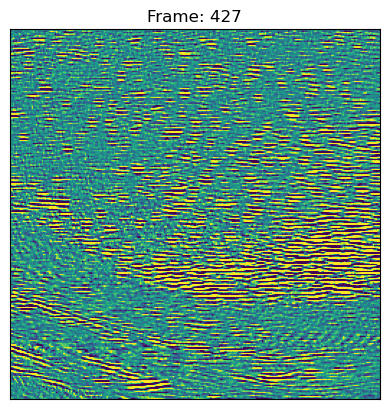

In [56]:
fileName = f'trunc_{first_index}-{last_index}_2.gif'
prodGif(aThresh_vid,fileName)

### Processing with Hilbert Transform

#### Figures for Hilbert Intuition 1D Case

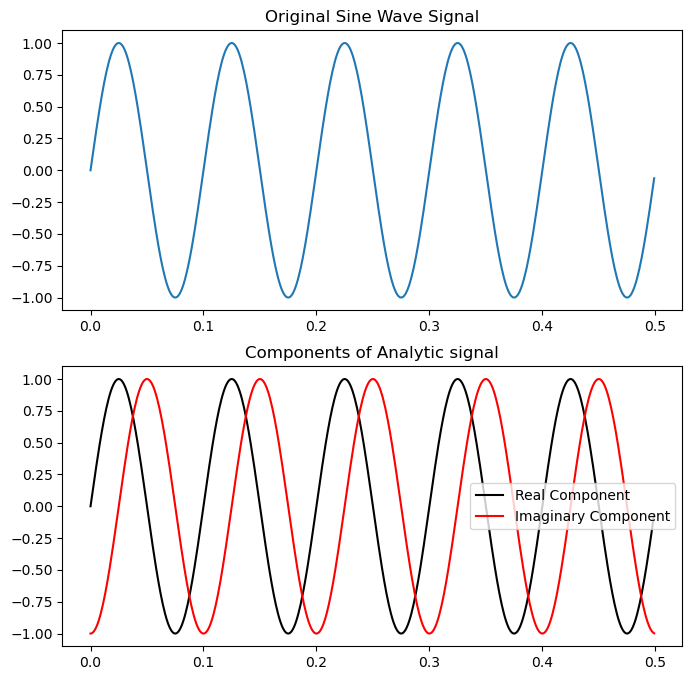

In [14]:
t = np.arange(start=0,stop=0.5,step=0.001)
x = np.sin(2*np.pi*10*t)
    
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(t,x)
plt.title('Original Sine Wave Signal')
    
z = scipy.signal.hilbert(x)
    
plt.subplot(2,1,2)
plt.plot(t,z.real,'k',label='Real Component')
plt.plot(t,z.imag,'r',label='Imaginary Component')
plt.title('Components of Analytic signal')
plt.legend()
plt.tight_layout

display()

In [15]:
analytic_signal = scipy.signal.hilbert(us_vid)

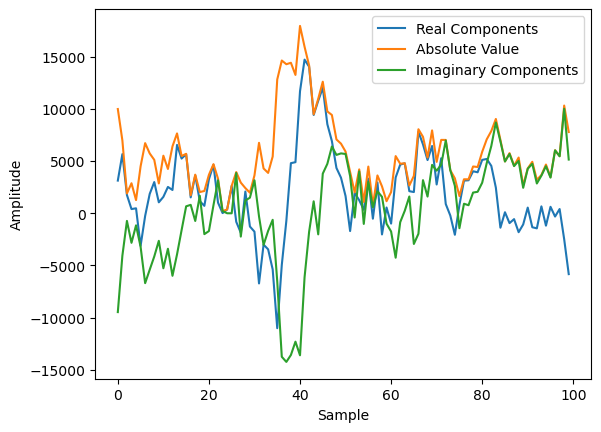

In [16]:
plt.plot(np.real(analytic_signal[0,0,0:100]))
plt.plot(np.abs(analytic_signal[0,0,0:100]))
plt.plot(np.imag(analytic_signal[0,0,0:100]))
plt.legend(["Real Components","Absolute Value", "Imaginary Components"])
plt.ylabel("Amplitude")
plt.xlabel("Sample")
display()

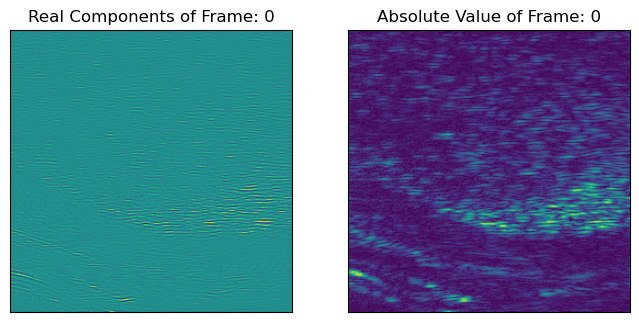

In [17]:
i = 0

fig, axes = plt.subplots(1,2, figsize=(8,4))

axes[0].imshow(np.real(analytic_signal[i]))
axes[0].set_title(f"Real Components of Frame: {i}")
axes[0].set_aspect('equal', adjustable='box')
axes[0].tick_params(axis='both',bottom=False,left=False,labelleft=False,labelbottom=False)

axes[1].imshow(np.abs(analytic_signal[i]))
axes[1].set_title(f"Absolute Value of Frame: {i}")
axes[1].set_aspect('equal', adjustable='box')
axes[1].tick_params(axis='both',bottom=False,left=False,labelleft=False,labelbottom=False)

display()

### (1b.) SVD–Arbitrary Threshold + Hilbert Transform

In [18]:
analytic_signal = scipy.signal.hilbert(us_vid)

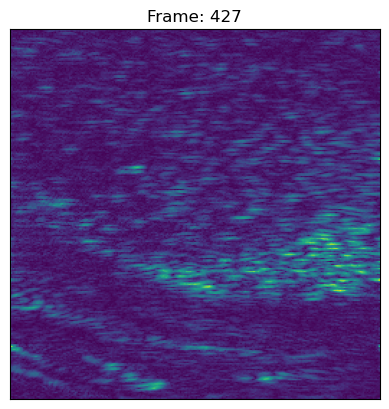

In [17]:
# fileName = f'trunc_{first_index}-{last_index}.gif'
fileName = 'unfiltered_us_Hilbert.gif'
prodGif(np.abs(analytic_signal),fileName)

## Spatial Similarity

In [192]:
u = np.abs(U)

In [193]:
SSM = np.divide((np.abs(u)-np.mean(u,axis=0)),np.std(u,axis=0))
SSM = np.matmul(SSM.T,SSM)
SSM /= 1/(257*257)

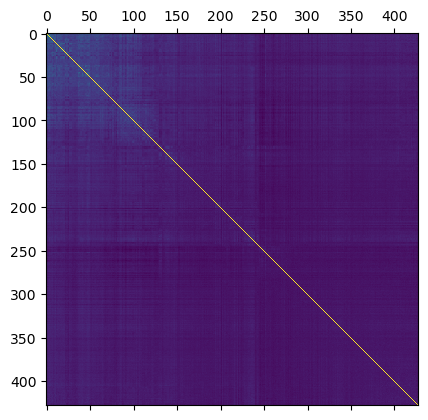

In [194]:
plt.matshow(SSM)
display()

In [185]:
first_index = 50    
last_index = 104

iF, new_vid = arbitrarySVD(U,S,Vh,first_index,last_index)

In [189]:
analytic_signal = scipy.signal.hilbert(new_vid)

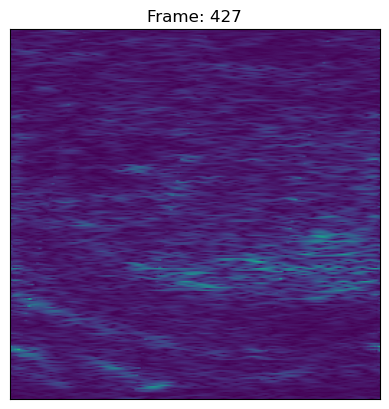

In [190]:
fileName = f'trunc_{first_index}-{last_index}.gif'
prodGif(np.abs(analytic_signal),fileName)

In [130]:
sr = S[2:] ** 2 / S[1:-1] ** 2

In [159]:
range = np.arange(0,len(sr),3)

for i in np.arange(1,len(range)):
    sr[range[i-1]:range[i]] /= np.average(sr[range[i-1]:range[i]])

In [162]:
sr /= sr.max()

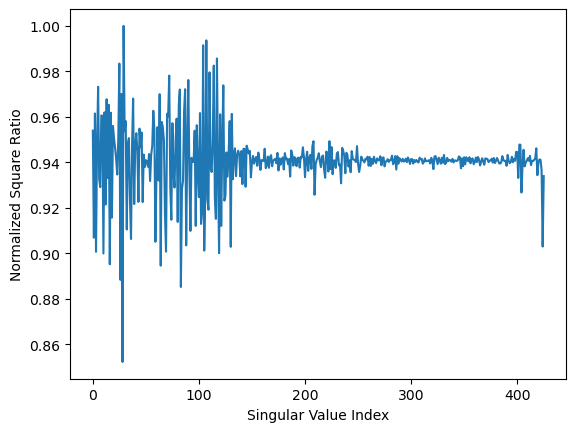

In [174]:
plt.plot(sr)
plt.xlabel('Singular Value Index')
plt.ylabel('Normalized Square Ratio')
display()

In [170]:
for i in np.arange(142):
    if sr[i] > 0.99:
        print(i)

29
104
107
